In [66]:
import sys
import os
import glob
from mpi4py import MPI
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format = 'png'

import floatpy.readers.padeops_reader as por
import floatpy.readers.parallel_reader as pdr
import floatpy.utilities.reduction as red
import floatpy.derivatives.compact.compact_derivative as cd
import scripts.statistics as stats
import scripts.get_namelist as nml
from scripts.common import *


def get_delta_u(directory,inp,flist,y,y0=0): #flist is lscales, y0 = [0,1,2]
    mat = np.zeros([len(flist),5])

    for i,fname in enumerate(flist):
        tID = fname.split('_')[-1]
        tID = int(tID.split('.dat')[0])
        time = nml.read_time(directory,tID)

        # Get y lengthscale and corresponding idx
        autocorr = np.fromfile(fname,sep=' ')
        autocorr = np.reshape(autocorr,[Ny,3])
        ly,i1,i2 = get_lscale(y,autocorr[:,y0],thresh=0.25)
        ny = int(Ny*ly/Ly)
        
        # Get corresponding du
        utilde = np.fromfile(directory+'/shearlayer_utilde_%04d.dat'%tID,sep=' ')
        ic = np.argmin(abs(utilde))
        du = abs(utilde[i2]-utilde[i1])
        
        # Get L99
        #L99,itop,ibot = get_L99(-y,utilde)
        
        # Plot to check
        #plt.plot(y,utilde)
        #plt.plot([y[i1],y[i2]],[0,0],'-o')
        #plt.plot([y[itop],y[ibot]],[0,0],'k-o')
        
        mat[i,0] = time
        mat[i,1] = du/inp.du
        mat[i,2] = ly
        mat[i,3] = du/ly # local shear
        
    isort = np.argsort(mat[:,0]) #sort time
    return mat[isort,:]

In [110]:
# directory='/lus/theta-fs0/projects/HighMachTurbulence/ShearLayerData/temporal/Mc02/rr1/1024x1448x512/'
directory = '/home/kmatsuno/ShearLayerData/production/Mc20/rr1/1024x1448x512/'
inp = nml.inputs(directory,verbose=True)
Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=True)
Ny = int(Ny)
x = np.linspace(0,Lx,Nx)
z = np.linspace(0,Lz,Nz)
y = np.linspace(-Ly/2.,Ly/2.,Ny)

# And read growth rates
tlist,dlist,rates = growth_rates(directory+'shearlayer_')

flist = glob.glob(directory+"*lscale_vv*")
flist.sort()
print([f.split('/')[-1] for f in flist])

Params for this run:
	Mc = 2.0
	Re = 1000.0
	rr = 1.0
Params for this grid:
	N = 1024x1448x512
	L = 80.0x80.0x40.0
['lscale_vv_0001.dat', 'lscale_vv_0002.dat', 'lscale_vv_0003.dat', 'lscale_vv_0004.dat', 'lscale_vv_0005.dat', 'lscale_vv_0006.dat', 'lscale_vv_0007.dat', 'lscale_vv_0008.dat', 'lscale_vv_0009.dat', 'lscale_vv_0010.dat', 'lscale_vv_0011.dat', 'lscale_vv_0012.dat', 'lscale_vv_0013.dat']


2.0:[0.135725941188,0.00807414561914],
2.0:[0.0970995886436,0.00976863446297],
2.0:[0.0980257581375,0.00512840835534],


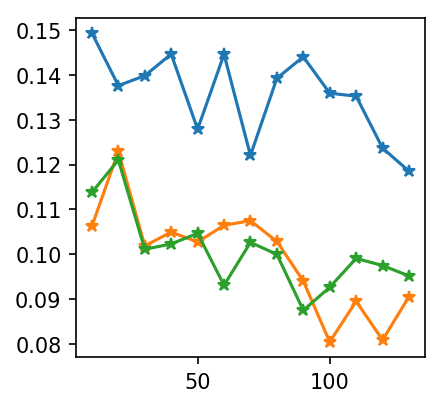

In [111]:

fig = plt.figure(figsize=(3,3),dpi=150)
dat = {}
dat[0] = get_delta_u(directory,inp,flist,y,y0=0)
dat[1] = get_delta_u(directory,inp,flist,y,y0=1)
dat[2] = get_delta_u(directory,inp,flist,y,y0=2)

t = dat[0][:,0]

ist = 2
ie = -1
istat = 1 #1: du/dU, 2:ly, 3: du/ly
for i in range(3):
    plt.plot(t,dat[i][:,1],'-*')
    print('{}:[{},{}],'.format(inp.Mc,np.mean(dat[i][ist:ie,istat]),np.std(dat[i][ist:ie,istat])))


In [102]:

du = {# Centered at y0=y_c
0.2:[0.320878628692,0.014354985748],
0.4:[0.28759238955,0.0173941871764],
0.8:[0.179652184681,0.012733736384],
1.2:[0.152164204092,0.0106738755021],
1.6:[0.144319916348,0.00952112341695],
2.0:[0.137327489666,0.00735651956894],
}
du_s7 = {
0.2:[0.212809887078,0.0174258713457],
0.8:[0.191486082107,0.0119116965823],
2.0:[0.137051163804,0.0110047225507],
}
du_top = {# Centered at y0=y_c+L99/4
0.2:[0.279738676551,0.0290261080669],
0.4:[0.230395351229,0.0133649171104],
0.8:[0.176372808684,0.0121096422929],
1.2:[0.148423382929,0.0106163406046],
1.6:[0.118806840856,0.00738065146849],
2.0:[0.100083806663,0.00837213712138],
}
du_bot = {# Centered at y0=y_c-L99/4
0.2:[0.300465875408,0.0234030480474],
0.4:[0.248748944949,0.0230791891151],
0.8:[0.185872710291,0.0164576917773],
1.2:[0.148550660507,0.0120033867856],
1.6:[0.115727491632,0.00927844122059],
2.0:[0.0979672802023,0.00571839589033],
}

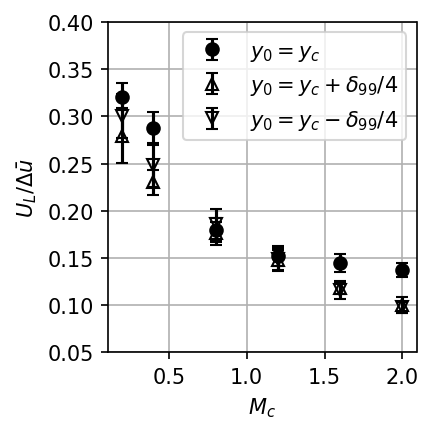

In [109]:
def plotter(dat,label,fmt,fillstyle='full'):
    plt.errorbar(dat.keys(),[x[0] for x in dat.values()], yerr=[x[1] for x in dat.values()],
                 fillstyle=fillstyle, fmt=fmt,label=label,capsize=3)
    
fig = plt.figure(figsize=(3,3),dpi=150)
plotter(du,r'$y_0=y_c$','ko')
plotter(du_top,r'$y_0=y_c+\delta_{99}/4$','k^',fillstyle='none')
plotter(du_bot,r'$y_0=y_c-\delta_{99}/4$','kv',fillstyle='none')

plt.grid(True)
plt.xlabel(r'$M_c$')
plt.ylabel(r'$U_L/\Delta \bar{u}$')
plt.ylim([0.05,0.4])
plt.tight_layout()
plt.legend()

0.2:[0.723512046038,0.0192347896173],
0.4:[0.659385230926,0.0209895662405],
0.8:[0.729700594396,0.0153437085665],
1.2:[0.705839915389,0.00408800379558],
1.6:[0.675763602087,0.00319802674588],
2.0:[0.565709536318,0.0169459530476],
Done


Text(0.5,0,'$t/\\Delta U$')

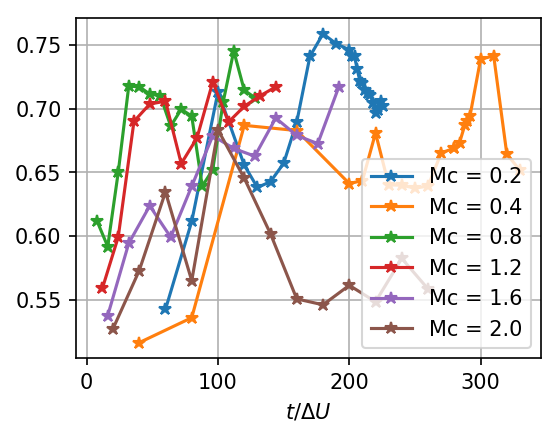

In [43]:
s = '1'

if s=='1': Mc_list = ['02','04','08','12','16','20']
else: Mc_list = ['02','08','20']
    
fig = plt.figure(figsize=(4,3),dpi=150)
ax = plt.axes()

for Mc in Mc_list:
    directory = '/home/kmatsuno/ShearLayerData/production/Mc%s/rr%s/1024x1448x512/'%(Mc,s)
    inp = nml.inputs(directory,verbose=False)
    Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=False)
    Ny = int(Ny)
    y = np.linspace(-Ly/2.,Ly/2.,Ny)
    
    flist = glob.glob(directory+"*lscale_vv*")
    dat = get_delta_u(directory,inp,flist[0:],y)
    
    dat[:,4] /= dat[:,3]
    istat = 4
    plt.plot(dat[:,0]*inp.Mc,dat[:,istat],'-*',label='Mc = {}'.format(inp.Mc))
    
    if Mc=='02': ist=9;ien=-1
    elif Mc=='04': ist=2;ien=13-4
    else: ist=-3; ien=-1
    print('{}:[{},{}],'.format(inp.Mc,np.mean(dat[ist:ien,istat]),np.std(dat[ist:ien,istat])))
    
print('Done')
ax.grid(True)
ax.legend()
ax.set_xlabel(r'$t/\Delta U$')
# ax.set_xlim([0,200]);
# plt.ylim([0,0.5])
# savename='/home/kmatsuno/ShearLayer_img/vs_t/lscale_%s_s%s'%(lscale,s)
# print(savename)
# fig.savefig(savename,dpi=200, bbox_inches='tight')

In [9]:
# Aspect ratios: v' decorrelations
ly_L99 = {# Ly/L99
0.2: [0.292311707867, 0.0297687961694],
0.4: [0.243424211239, 0.0311123554003],
0.8: [0.150082552447, 0.0071441579158],
1.2: [0.130016668321, 0.0104314411831],
1.6: [0.115630797425, 0.00695978637297],
2.0: [0.104827927243, 0.00953968043139],
}
lx_L99 = { # lx/L99
0.2: [0.521318569327, 0.0395020583657],
0.4: [0.451137946375, 0.0512538138099],
0.8: [0.267320052369, 0.011683596225],
1.2: [0.234510200214, 0.0258215189548],
1.6: [0.198769543519, 0.0220920650474],
2.0: [0.184273076222, 0.0221718306893],
}
lx_ly = {
0.2: [1.75989443707, 0.114665522974],
0.4: [1.91583330042, 0.162291378435],
0.8: [1.76234636862, 0.0881001617297],
1.2: [1.80683930355, 0.167975144252],
1.6: [1.72959575559, 0.157338293607],
2.0: [1.7774207714, 0.186547036638],
}
lz_ly = {
0.2: [1.22163665548, 0.110775997749],
0.4: [1.24418935067, 0.108192146985],
0.8: [1.08811839932, 0.0950757164193],
1.2: [1.08788475146, 0.0610885789127],
1.6: [1.11658725844, 0.0971401343019],
2.0: [1.07458790835, 0.110625362821],
}

cases = { 
0.2:'A1',
0.4:'B1',
0.8:'C1',
1.2:'D1',
1.6:'E1',
2.0:'F1',}

for key in sorted(du.keys()):
    print('{} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\'.format(
        key,ly_L99[key][0],lx_L99[key][0],lx_ly[key][0],lz_ly[key][0],du[key][0]))

0.2 & 0.29 & 0.52 & 1.76 & 1.22 & 0.32 \\
0.4 & 0.24 & 0.45 & 1.92 & 1.24 & 0.29 \\
0.8 & 0.15 & 0.27 & 1.76 & 1.09 & 0.18 \\
1.2 & 0.13 & 0.23 & 1.81 & 1.09 & 0.15 \\
1.6 & 0.12 & 0.20 & 1.73 & 1.12 & 0.14 \\
2.0 & 0.10 & 0.18 & 1.78 & 1.07 & 0.14 \\
